In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

# constants
IN_CHANNELS = 2
OUT_CHANNELS = IN_CHANNELS
BATCH_SIZE = 8
AE_EPOCHS = 2000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Imported')
print('Used device:', device)

Imported
Used device: cuda


### Data preprocessing

In [2]:
class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, *data):
        self.data = data

    def __len__(self):
        return self.data[-1].__len__()

    def __getitem__(self, index):
        return [d[index] for d in self.data]
    
# loading dataset
data = np.load('./data/brats_3d_dataset.npy')
flair, t1ce, mask = data[:, 0, None, ...], data[:, 1, None, ...], data[:, 2, None, ...]

# normalizing the data
n_max_flair = [flair[i].max() for i in range(flair.shape[0])]
n_max_t1ce = [t1ce[i].max() for i in range(t1ce.shape[0])]

for idx in range(0, flair.shape[0]):
    flair[idx] = (flair[idx] / n_max_flair[idx]).astype(np.float32)
    t1ce[idx] = (t1ce[idx] / n_max_t1ce[idx]).astype(np.float32)

# transforming from 3D to 2D
def to_3d(data):
    data = data.transpose(0, 4, 1, 2, 3)
    data = data.reshape(-1, data.shape[2], data.shape[3], data.shape[4])
    return data

flair, t1ce, mask = to_3d(flair), to_3d(t1ce), to_3d(mask)

# removing empty slices
empty_slices_indices = np.where(np.any(flair, axis=(1, 2, 3)) == True)[0]
flair, t1ce, mask = flair[empty_slices_indices], t1ce[empty_slices_indices], mask[empty_slices_indices]

# going from 0, 1 to -1, 1
flair = flair * 2 - 1
t1ce = t1ce * 2 - 1

# dataset and dataloader
n_samples = 5000
train_dataset = IdentityDataset(flair[:n_samples], t1ce[:n_samples], mask[:n_samples])
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=8, pin_memory=True
)

print('Data shape: {}'.format(flair.shape))
print('Max: {}'.format(flair.max()))
print('Min: {}'.format(flair.min()))
print('Data loaded')

Data shape: (28955, 1, 128, 128)
Max: 1.0
Min: -1.0179553423076868
Data loaded


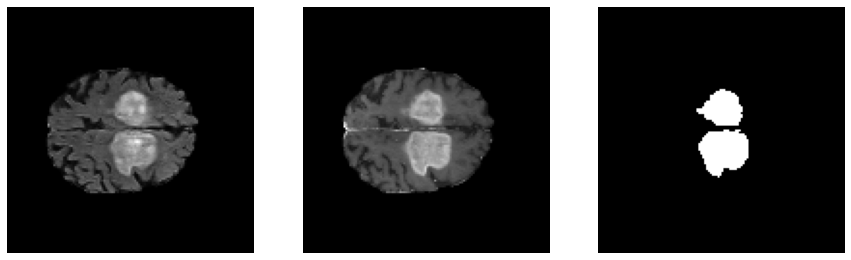

In [3]:
plt.figure(figsize=(15, 5))
for idx, vec in enumerate([flair, t1ce, mask]):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(vec[25000, 0, ...], cmap='gray')
    plt.axis('off')
plt.show()

### Training reconstruction model

In [9]:
# function that format dict to string properly
def format_dict(d):
    return ' -- '.join([f'{k}: {v:.4f}' for k, v in d.items()])

train/total_loss: 0.4857 -- train/quant_loss: 0.6200 -- train/nll_loss: 0.0885 -- train/rec_loss: 0.0885 -- train/p_loss: 0.0636 -- train/d_weight: 0.2810 -- train/disc_factor: 1.0000 -- train/g_loss: -0.7930 -- train/disc_loss: 0.9922 -- train/logits_real: 0.8174 -- train/logits_fake: 0.7930:  65%|██████▌   | 407/625 [01:46<00:56,  3.83it/s]
train/total_loss: 0.6317 -- train/quant_loss: 0.7309 -- train/nll_loss: 0.1487 -- train/rec_loss: 0.1487 -- train/p_loss: 0.1094 -- train/d_weight: 0.3413 -- train/disc_factor: 1.0000 -- train/g_loss: -0.7266 -- train/disc_loss: 0.9995 -- train/logits_real: 0.7393 -- train/logits_fake: 0.7266: 100%|██████████| 625/625 [01:13<00:00,  8.46it/s]
train/total_loss: 0.5249 -- train/quant_loss: 0.4880 -- train/nll_loss: 0.0891 -- train/rec_loss: 0.0891 -- train/p_loss: 0.0656 -- train/d_weight: 0.0814 -- train/disc_factor: 1.0000 -- train/g_loss: -0.6416 -- train/disc_loss: 0.9712 -- train/logits_real: 0.7021 -- train/logits_fake: 0.6416: 100%|██████████

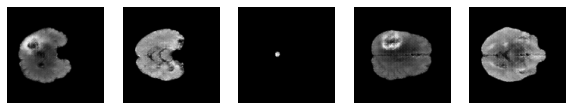

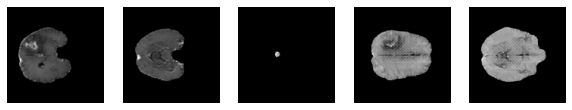

train/total_loss: -0.1238 -- train/quant_loss: 0.0191 -- train/nll_loss: 0.0746 -- train/rec_loss: 0.0746 -- train/p_loss: 0.0430 -- train/d_weight: 0.0371 -- train/disc_factor: 1.0000 -- train/g_loss: -5.8672 -- train/disc_loss: 3.4336 -- train/logits_real: 5.3828 -- train/logits_fake: 5.8672: 100%|██████████| 625/625 [01:16<00:00,  8.19it/s]
train/total_loss: -0.0363 -- train/quant_loss: 0.0153 -- train/nll_loss: 0.0688 -- train/rec_loss: 0.0688 -- train/p_loss: 0.0431 -- train/d_weight: 0.0598 -- train/disc_factor: 1.0000 -- train/g_loss: -2.0137 -- train/disc_loss: 1.5068 -- train/logits_real: 1.8516 -- train/logits_fake: 2.0137: 100%|██████████| 625/625 [01:16<00:00,  8.21it/s]
train/total_loss: -0.1738 -- train/quant_loss: 0.0131 -- train/nll_loss: 0.0646 -- train/rec_loss: 0.0646 -- train/p_loss: 0.0407 -- train/d_weight: 0.0744 -- train/disc_factor: 1.0000 -- train/g_loss: -3.3789 -- train/disc_loss: 2.1895 -- train/logits_real: 3.1875 -- train/logits_fake: 3.3789: 100%|███████

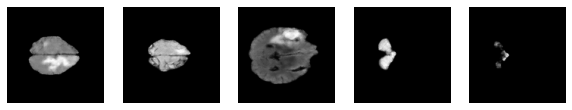

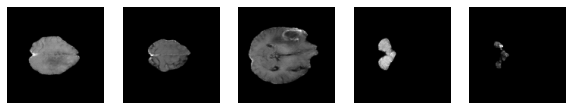

train/total_loss: -0.0667 -- train/quant_loss: 0.0057 -- train/nll_loss: 0.0359 -- train/rec_loss: 0.0359 -- train/p_loss: 0.0208 -- train/d_weight: 0.0415 -- train/disc_factor: 1.0000 -- train/g_loss: -2.6074 -- train/disc_loss: 1.8037 -- train/logits_real: 2.5625 -- train/logits_fake: 2.6074: 100%|██████████| 625/625 [01:16<00:00,  8.21it/s]
train/total_loss: -0.0315 -- train/quant_loss: 0.0056 -- train/nll_loss: 0.0336 -- train/rec_loss: 0.0336 -- train/p_loss: 0.0192 -- train/d_weight: 0.0608 -- train/disc_factor: 1.0000 -- train/g_loss: -1.1631 -- train/disc_loss: 1.0840 -- train/logits_real: 1.1094 -- train/logits_fake: 1.1631: 100%|██████████| 625/625 [01:14<00:00,  8.35it/s]
train/total_loss: 0.0065 -- train/quant_loss: 0.0068 -- train/nll_loss: 0.0424 -- train/rec_loss: 0.0424 -- train/p_loss: 0.0242 -- train/d_weight: 0.0353 -- train/disc_factor: 1.0000 -- train/g_loss: -1.2070 -- train/disc_loss: 1.1035 -- train/logits_real: 1.1787 -- train/logits_fake: 1.2070: 100%|████████

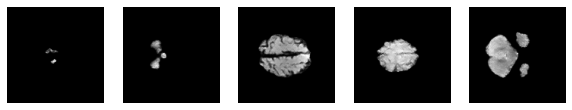

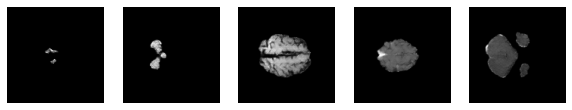

train/total_loss: -0.0221 -- train/quant_loss: 0.0025 -- train/nll_loss: 0.0213 -- train/rec_loss: 0.0213 -- train/p_loss: 0.0125 -- train/d_weight: 0.0423 -- train/disc_factor: 1.0000 -- train/g_loss: -1.0859 -- train/disc_loss: 1.0605 -- train/logits_real: 1.0400 -- train/logits_fake: 1.0859: 100%|██████████| 625/625 [01:18<00:00,  7.94it/s]
train/total_loss: -0.0414 -- train/quant_loss: 0.0036 -- train/nll_loss: 0.0321 -- train/rec_loss: 0.0321 -- train/p_loss: 0.0173 -- train/d_weight: 0.0356 -- train/disc_factor: 1.0000 -- train/g_loss: -2.1660 -- train/disc_loss: 1.5830 -- train/logits_real: 2.0664 -- train/logits_fake: 2.1660: 100%|██████████| 625/625 [01:16<00:00,  8.19it/s]
train/total_loss: -0.2080 -- train/quant_loss: 0.0047 -- train/nll_loss: 0.0342 -- train/rec_loss: 0.0342 -- train/p_loss: 0.0185 -- train/d_weight: 0.0679 -- train/disc_factor: 1.0000 -- train/g_loss: -3.6348 -- train/disc_loss: 2.3184 -- train/logits_real: 3.4863 -- train/logits_fake: 3.6348: 100%|███████

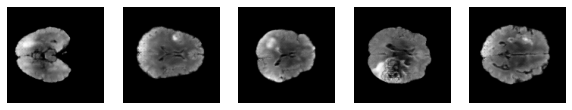

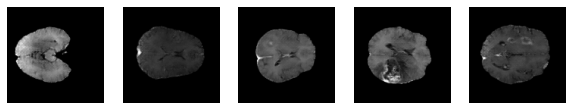

train/total_loss: -0.0261 -- train/quant_loss: 0.0038 -- train/nll_loss: 0.0531 -- train/rec_loss: 0.0531 -- train/p_loss: 0.0230 -- train/d_weight: 0.0378 -- train/disc_factor: 1.0000 -- train/g_loss: -2.1934 -- train/disc_loss: 1.5967 -- train/logits_real: 1.8672 -- train/logits_fake: 2.1934: 100%|██████████| 625/625 [01:17<00:00,  8.03it/s]
train/total_loss: -0.0239 -- train/quant_loss: 0.0037 -- train/nll_loss: 0.0558 -- train/rec_loss: 0.0558 -- train/p_loss: 0.0213 -- train/d_weight: 0.0445 -- train/disc_factor: 1.0000 -- train/g_loss: -1.8740 -- train/disc_loss: 1.4375 -- train/logits_real: 1.3721 -- train/logits_fake: 1.8740: 100%|██████████| 625/625 [01:13<00:00,  8.45it/s]
train/total_loss: -0.1884 -- train/quant_loss: 0.0032 -- train/nll_loss: 0.0426 -- train/rec_loss: 0.0426 -- train/p_loss: 0.0178 -- train/d_weight: 0.1031 -- train/disc_factor: 1.0000 -- train/g_loss: -2.2715 -- train/disc_loss: 1.6357 -- train/logits_real: 1.9287 -- train/logits_fake: 2.2715: 100%|███████

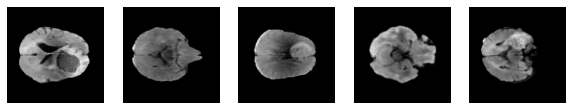

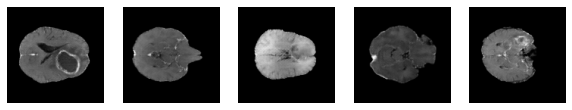

train/total_loss: -0.1131 -- train/quant_loss: 0.0035 -- train/nll_loss: 0.0425 -- train/rec_loss: 0.0425 -- train/p_loss: 0.0166 -- train/d_weight: 0.0585 -- train/disc_factor: 1.0000 -- train/g_loss: -2.7207 -- train/disc_loss: 1.8604 -- train/logits_real: 2.4316 -- train/logits_fake: 2.7207: 100%|██████████| 625/625 [01:16<00:00,  8.15it/s]
train/total_loss: -0.1734 -- train/quant_loss: 0.0025 -- train/nll_loss: 0.0405 -- train/rec_loss: 0.0405 -- train/p_loss: 0.0157 -- train/d_weight: 0.1090 -- train/disc_factor: 1.0000 -- train/g_loss: -1.9854 -- train/disc_loss: 1.4922 -- train/logits_real: 1.6660 -- train/logits_fake: 1.9854: 100%|██████████| 625/625 [01:15<00:00,  8.25it/s]
train/total_loss: -0.0942 -- train/quant_loss: 0.0031 -- train/nll_loss: 0.0356 -- train/rec_loss: 0.0356 -- train/p_loss: 0.0148 -- train/d_weight: 0.0627 -- train/disc_factor: 1.0000 -- train/g_loss: -2.1211 -- train/disc_loss: 1.5605 -- train/logits_real: 1.8750 -- train/logits_fake: 2.1211: 100%|███████

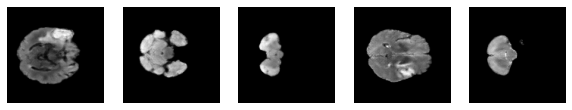

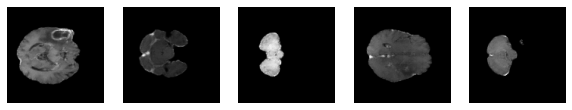

train/total_loss: -0.2601 -- train/quant_loss: 0.0028 -- train/nll_loss: 0.0342 -- train/rec_loss: 0.0342 -- train/p_loss: 0.0132 -- train/d_weight: 0.1124 -- train/disc_factor: 1.0000 -- train/g_loss: -2.6426 -- train/disc_loss: 1.8213 -- train/logits_real: 2.3281 -- train/logits_fake: 2.6426: 100%|██████████| 625/625 [01:15<00:00,  8.27it/s]
train/total_loss: -0.4849 -- train/quant_loss: 0.0033 -- train/nll_loss: 0.0406 -- train/rec_loss: 0.0406 -- train/p_loss: 0.0174 -- train/d_weight: 0.1456 -- train/disc_factor: 1.0000 -- train/g_loss: -3.6328 -- train/disc_loss: 2.3164 -- train/logits_real: 3.4805 -- train/logits_fake: 3.6328: 100%|██████████| 625/625 [01:15<00:00,  8.30it/s]
train/total_loss: -0.2211 -- train/quant_loss: 0.0022 -- train/nll_loss: 0.0234 -- train/rec_loss: 0.0234 -- train/p_loss: 0.0098 -- train/d_weight: 0.0740 -- train/disc_factor: 1.0000 -- train/g_loss: -3.3320 -- train/disc_loss: 2.1660 -- train/logits_real: 3.2227 -- train/logits_fake: 3.3320: 100%|███████

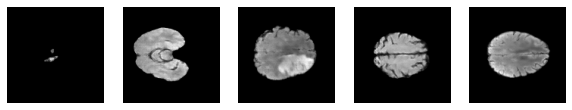

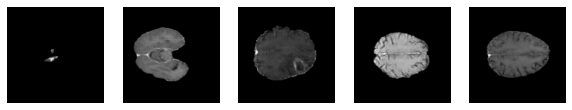

train/total_loss: -4.3455 -- train/quant_loss: 0.0023 -- train/nll_loss: 0.0242 -- train/rec_loss: 0.0242 -- train/p_loss: 0.0120 -- train/d_weight: 0.0820 -- train/disc_factor: 1.0000 -- train/g_loss: -53.3438 -- train/disc_loss: 27.1719 -- train/logits_real: 53.2812 -- train/logits_fake: 53.3438: 100%|██████████| 625/625 [01:15<00:00,  8.25it/s]
train/total_loss: -15.4132 -- train/quant_loss: 0.0023 -- train/nll_loss: 0.0267 -- train/rec_loss: 0.0267 -- train/p_loss: 0.0132 -- train/d_weight: 0.2228 -- train/disc_factor: 1.0000 -- train/g_loss: -69.3125 -- train/disc_loss: 35.1562 -- train/logits_real: 69.1875 -- train/logits_fake: 69.3125: 100%|██████████| 625/625 [01:14<00:00,  8.44it/s]
train/total_loss: -11.0325 -- train/quant_loss: 0.0024 -- train/nll_loss: 0.0279 -- train/rec_loss: 0.0279 -- train/p_loss: 0.0147 -- train/d_weight: 0.1286 -- train/disc_factor: 1.0000 -- train/g_loss: -86.0000 -- train/disc_loss: 43.5000 -- train/logits_real: 85.8125 -- train/logits_fake: 86.0000

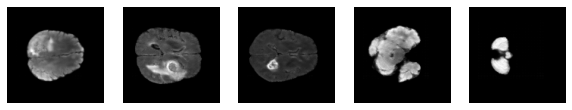

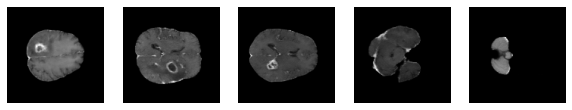

train/total_loss: -47.8229 -- train/quant_loss: 0.0022 -- train/nll_loss: 0.0204 -- train/rec_loss: 0.0204 -- train/p_loss: 0.0103 -- train/d_weight: 0.0464 -- train/disc_factor: 1.0000 -- train/g_loss: -1031.0000 -- train/disc_loss: 516.0000 -- train/logits_real: 1030.0000 -- train/logits_fake: 1031.0000: 100%|██████████| 625/625 [01:16<00:00,  8.18it/s]
train/total_loss: -65.6905 -- train/quant_loss: 0.0025 -- train/nll_loss: 0.0219 -- train/rec_loss: 0.0219 -- train/p_loss: 0.0104 -- train/d_weight: 0.0616 -- train/disc_factor: 1.0000 -- train/g_loss: -1066.0000 -- train/disc_loss: 533.5000 -- train/logits_real: 1065.0000 -- train/logits_fake: 1066.0000: 100%|██████████| 625/625 [01:17<00:00,  8.10it/s] 
train/total_loss: -20.5598 -- train/quant_loss: 0.0028 -- train/nll_loss: 0.0262 -- train/rec_loss: 0.0262 -- train/p_loss: 0.0123 -- train/d_weight: 0.0187 -- train/disc_factor: 1.0000 -- train/g_loss: -1099.0000 -- train/disc_loss: 550.0000 -- train/logits_real: 1098.0000 -- train

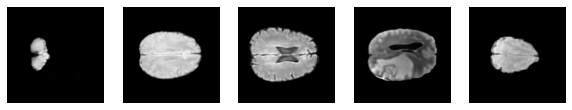

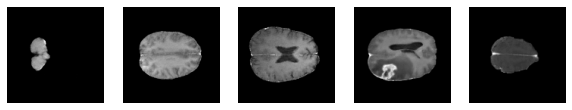

train/total_loss: -16.8170 -- train/quant_loss: 0.0023 -- train/nll_loss: 0.0207 -- train/rec_loss: 0.0207 -- train/p_loss: 0.0089 -- train/d_weight: 0.0051 -- train/disc_factor: 1.0000 -- train/g_loss: -3316.0000 -- train/disc_loss: 1658.0000 -- train/logits_real: 3314.0000 -- train/logits_fake: 3316.0000: 100%|██████████| 625/625 [01:15<00:00,  8.24it/s]
train/total_loss: -68.6761 -- train/quant_loss: 0.0022 -- train/nll_loss: 0.0189 -- train/rec_loss: 0.0189 -- train/p_loss: 0.0085 -- train/d_weight: 0.0204 -- train/disc_factor: 1.0000 -- train/g_loss: -3374.0000 -- train/disc_loss: 1687.0000 -- train/logits_real: 3372.0000 -- train/logits_fake: 3374.0000: 100%|██████████| 625/625 [01:14<00:00,  8.36it/s] 
train/total_loss: -30.8623 -- train/quant_loss: 0.0022 -- train/nll_loss: 0.0228 -- train/rec_loss: 0.0228 -- train/p_loss: 0.0100 -- train/d_weight: 0.0090 -- train/disc_factor: 1.0000 -- train/g_loss: -3436.0000 -- train/disc_loss: 1718.0000 -- train/logits_real: 3432.0000 -- tr

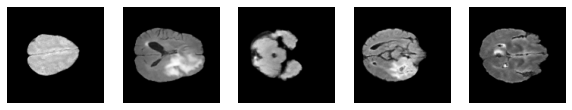

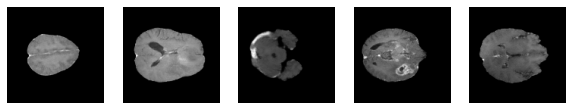

train/total_loss: -428.4885 -- train/quant_loss: 0.0020 -- train/nll_loss: 0.0192 -- train/rec_loss: 0.0192 -- train/p_loss: 0.0085 -- train/d_weight: 0.0883 -- train/disc_factor: 1.0000 -- train/g_loss: -4852.0000 -- train/disc_loss: 2426.0000 -- train/logits_real: 4852.0000 -- train/logits_fake: 4852.0000: 100%|██████████| 625/625 [01:17<00:00,  8.11it/s]
train/total_loss: -218.7148 -- train/quant_loss: 0.0019 -- train/nll_loss: 0.0168 -- train/rec_loss: 0.0168 -- train/p_loss: 0.0078 -- train/d_weight: 0.0451 -- train/disc_factor: 1.0000 -- train/g_loss: -4852.0000 -- train/disc_loss: 2426.0000 -- train/logits_real: 4852.0000 -- train/logits_fake: 4852.0000: 100%|██████████| 625/625 [01:15<00:00,  8.23it/s] 
train/total_loss: -569.4504 -- train/quant_loss: 0.0019 -- train/nll_loss: 0.0180 -- train/rec_loss: 0.0180 -- train/p_loss: 0.0081 -- train/d_weight: 0.1174 -- train/disc_factor: 1.0000 -- train/g_loss: -4852.0000 -- train/disc_loss: 2426.0000 -- train/logits_real: 4852.0000 --

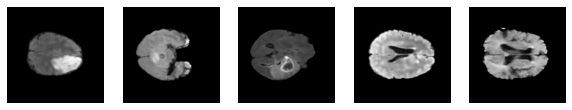

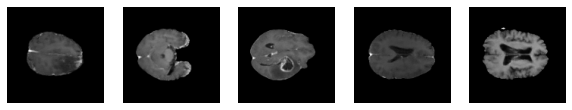

train/total_loss: -419.1747 -- train/quant_loss: 0.0021 -- train/nll_loss: 0.0201 -- train/rec_loss: 0.0201 -- train/p_loss: 0.0086 -- train/d_weight: 0.0864 -- train/disc_factor: 1.0000 -- train/g_loss: -4852.0000 -- train/disc_loss: 2426.0000 -- train/logits_real: 4852.0000 -- train/logits_fake: 4852.0000: 100%|██████████| 625/625 [01:15<00:00,  8.31it/s]
train/total_loss: -415.5127 -- train/quant_loss: 0.0018 -- train/nll_loss: 0.0179 -- train/rec_loss: 0.0179 -- train/p_loss: 0.0078 -- train/d_weight: 0.0856 -- train/disc_factor: 1.0000 -- train/g_loss: -4852.0000 -- train/disc_loss: 2426.0000 -- train/logits_real: 4852.0000 -- train/logits_fake: 4852.0000: 100%|██████████| 625/625 [01:15<00:00,  8.32it/s]  
train/total_loss: -1983.7292 -- train/quant_loss: 0.0019 -- train/nll_loss: 0.0175 -- train/rec_loss: 0.0175 -- train/p_loss: 0.0074 -- train/d_weight: 0.4089 -- train/disc_factor: 1.0000 -- train/g_loss: -4852.0000 -- train/disc_loss: 2426.0000 -- train/logits_real: 4852.0000 

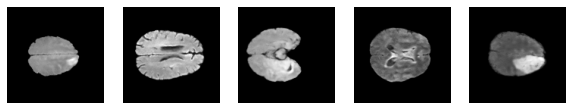

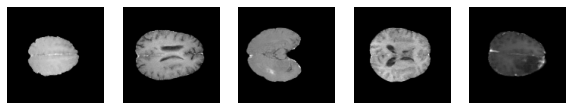

train/total_loss: nan -- train/quant_loss: 0.0017 -- train/nll_loss: 0.0202 -- train/rec_loss: 0.0202 -- train/p_loss: 0.0090 -- train/d_weight: nan -- train/disc_factor: 1.0000 -- train/g_loss: nan -- train/disc_loss: nan -- train/logits_real: nan -- train/logits_fake: nan: 100%|██████████| 625/625 [01:10<00:00,  8.90it/s]
train/total_loss: nan -- train/quant_loss: 0.0018 -- train/nll_loss: 0.0196 -- train/rec_loss: 0.0196 -- train/p_loss: 0.0084 -- train/d_weight: nan -- train/disc_factor: 1.0000 -- train/g_loss: nan -- train/disc_loss: nan -- train/logits_real: nan -- train/logits_fake: nan: 100%|██████████| 625/625 [01:09<00:00,  8.99it/s]
train/total_loss: nan -- train/quant_loss: 0.0016 -- train/nll_loss: 0.0164 -- train/rec_loss: 0.0164 -- train/p_loss: 0.0076 -- train/d_weight: nan -- train/disc_factor: 1.0000 -- train/g_loss: nan -- train/disc_loss: nan -- train/logits_real: nan -- train/logits_fake: nan: 100%|██████████| 625/625 [01:11<00:00,  8.76it/s]
train/total_loss: nan 

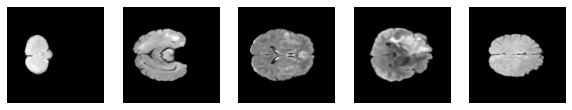

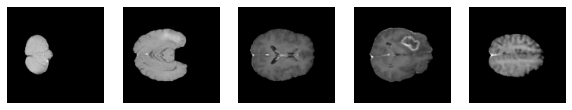

train/total_loss: nan -- train/quant_loss: 0.0014 -- train/nll_loss: 0.0138 -- train/rec_loss: 0.0138 -- train/p_loss: 0.0065 -- train/d_weight: nan -- train/disc_factor: 1.0000 -- train/g_loss: nan -- train/disc_loss: nan -- train/logits_real: nan -- train/logits_fake: nan: 100%|██████████| 625/625 [01:11<00:00,  8.79it/s]
train/total_loss: nan -- train/quant_loss: 0.0013 -- train/nll_loss: 0.0113 -- train/rec_loss: 0.0113 -- train/p_loss: 0.0053 -- train/d_weight: nan -- train/disc_factor: 1.0000 -- train/g_loss: nan -- train/disc_loss: nan -- train/logits_real: nan -- train/logits_fake: nan: 100%|██████████| 625/625 [01:10<00:00,  8.88it/s]
train/total_loss: nan -- train/quant_loss: 0.0016 -- train/nll_loss: 0.0146 -- train/rec_loss: 0.0146 -- train/p_loss: 0.0061 -- train/d_weight: nan -- train/disc_factor: 1.0000 -- train/g_loss: nan -- train/disc_loss: nan -- train/logits_real: nan -- train/logits_fake: nan: 100%|██████████| 625/625 [01:11<00:00,  8.76it/s]
train/total_loss: nan 

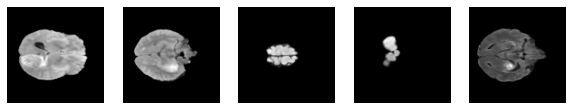

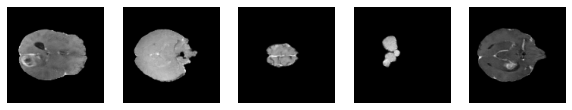

train/total_loss: nan -- train/quant_loss: 0.0015 -- train/nll_loss: 0.0151 -- train/rec_loss: 0.0151 -- train/p_loss: 0.0063 -- train/d_weight: nan -- train/disc_factor: 1.0000 -- train/g_loss: nan -- train/disc_loss: nan -- train/logits_real: nan -- train/logits_fake: nan: 100%|██████████| 625/625 [01:10<00:00,  8.87it/s]
train/total_loss: nan -- train/quant_loss: 0.0017 -- train/nll_loss: 0.0181 -- train/rec_loss: 0.0181 -- train/p_loss: 0.0082 -- train/d_weight: nan -- train/disc_factor: 1.0000 -- train/g_loss: nan -- train/disc_loss: nan -- train/logits_real: nan -- train/logits_fake: nan: 100%|██████████| 625/625 [01:09<00:00,  8.95it/s]
train/total_loss: nan -- train/quant_loss: 0.0015 -- train/nll_loss: 0.0152 -- train/rec_loss: 0.0152 -- train/p_loss: 0.0071 -- train/d_weight: nan -- train/disc_factor: 1.0000 -- train/g_loss: nan -- train/disc_loss: nan -- train/logits_real: nan -- train/logits_fake: nan: 100%|██████████| 625/625 [01:10<00:00,  8.88it/s]
train/total_loss: nan 

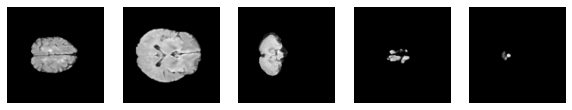

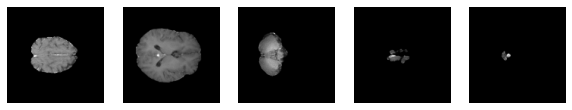

train/total_loss: nan -- train/quant_loss: 0.0013 -- train/nll_loss: 0.0139 -- train/rec_loss: 0.0139 -- train/p_loss: 0.0069 -- train/d_weight: nan -- train/disc_factor: 1.0000 -- train/g_loss: nan -- train/disc_loss: nan -- train/logits_real: nan -- train/logits_fake: nan: 100%|██████████| 625/625 [01:11<00:00,  8.76it/s]
train/total_loss: nan -- train/quant_loss: 0.0016 -- train/nll_loss: 0.0177 -- train/rec_loss: 0.0177 -- train/p_loss: 0.0078 -- train/d_weight: nan -- train/disc_factor: 1.0000 -- train/g_loss: nan -- train/disc_loss: nan -- train/logits_real: nan -- train/logits_fake: nan: 100%|██████████| 625/625 [01:09<00:00,  9.05it/s]
train/total_loss: nan -- train/quant_loss: 0.0017 -- train/nll_loss: 0.0169 -- train/rec_loss: 0.0169 -- train/p_loss: 0.0079 -- train/d_weight: nan -- train/disc_factor: 1.0000 -- train/g_loss: nan -- train/disc_loss: nan -- train/logits_real: nan -- train/logits_fake: nan: 100%|██████████| 625/625 [01:08<00:00,  9.06it/s]
train/total_loss: nan 

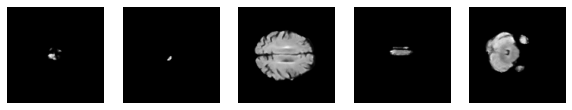

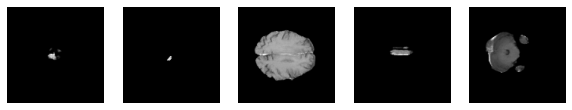

train/total_loss: nan -- train/quant_loss: 0.0011 -- train/nll_loss: 0.0101 -- train/rec_loss: 0.0101 -- train/p_loss: 0.0051 -- train/d_weight: nan -- train/disc_factor: 1.0000 -- train/g_loss: nan -- train/disc_loss: nan -- train/logits_real: nan -- train/logits_fake: nan: 100%|██████████| 625/625 [01:10<00:00,  8.87it/s]
train/total_loss: nan -- train/quant_loss: 0.0020 -- train/nll_loss: 0.0239 -- train/rec_loss: 0.0239 -- train/p_loss: 0.0108 -- train/d_weight: nan -- train/disc_factor: 1.0000 -- train/g_loss: nan -- train/disc_loss: nan -- train/logits_real: nan -- train/logits_fake: nan: 100%|██████████| 625/625 [01:09<00:00,  8.99it/s]
train/total_loss: nan -- train/quant_loss: 0.0014 -- train/nll_loss: 0.0150 -- train/rec_loss: 0.0150 -- train/p_loss: 0.0067 -- train/d_weight: nan -- train/disc_factor: 1.0000 -- train/g_loss: nan -- train/disc_loss: nan -- train/logits_real: nan -- train/logits_fake: nan: 100%|██████████| 625/625 [01:09<00:00,  8.94it/s]
train/total_loss: nan 

KeyboardInterrupt: 

In [12]:
from models.vector_quantized_autoencoder import VQAutoencoder
from models.lpips import VQLPIPSWithDiscriminator

def count_params(model, verbose=False):
    total_params = sum(p.numel() for p in model.parameters())
    if verbose:
        print(f"{model.__class__.__name__} has {total_params * 1.e-6:.2f} M params.")
    return total_params

AMP = True
accumulation_steps = 1
torch.backends.cudnn.benchmark = True

ae = VQAutoencoder(
    IN_CHANNELS, OUT_CHANNELS, n_embed=8192, embed_dim=3, 
    z_channels=4, z_double=False, num_channels=128,
    channels_mult=[1, 2, 4], num_res_blocks=2
).to(device)

loss = VQLPIPSWithDiscriminator(
    disc_start=11, codebook_weight=1.0, pixel_weight=1.0, perceptual_weight=1.0,
    disc_weight=0.75, d_input_channels=IN_CHANNELS, d_channels=64, d_num_layers=3
).to(device)

# model = torch.compile(model)

count_params(ae, verbose=True)

lr_g_factor = 1.0
ae_optimizer = torch.optim.AdamW(ae.parameters(), lr=0.00001, weight_decay=1e-7, betas=(0.5, 0.9))
d_optimizer = torch.optim.AdamW(loss.discriminator.parameters(), lr=lr_g_factor * 0.00001, weight_decay=1e-7, betas=(0.5, 0.9))

# lets try first without scheduler
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     ae_optimizer, T_max=train_loader.__len__() * AE_EPOCHS, eta_min=1e-9, last_epoch=-1
# )

ae_scaler = torch.cuda.amp.GradScaler(enabled=AMP)
d_scaler = torch.cuda.amp.GradScaler(enabled=AMP)
total_loss_history = []

for epoch in range(AE_EPOCHS):
    ae.train()
    ae_optimizer.zero_grad(set_to_none=True)
    total_accumulated_loss = []
    ae_accumulate_loss, d_accumulated_loss = [], []

    progress = tqdm(train_loader, position=0, leave=True)
    for idx, (flair, t1ce, _) in enumerate(train_loader):
        B = flair.shape[0]
        flair = flair.to(device, dtype=torch.float32, non_blocking=True)
        t1ce = t1ce.to(device, dtype=torch.float32, non_blocking=True)
        # masks = masks.to(device, dtype=torch.float32, non_blocking=True)

        with torch.autocast(device.type, enabled=AMP):
            x = torch.cat([flair, t1ce], dim=1)
            x_recon, qloss, ind = ae(x, return_indices=True)
            
            ae_loss, log_dict_ae = loss(
                qloss, x, torch.tanh(x_recon), 0, epoch * len(train_loader) + idx, last_layer=ae.decoder.out_conv[-1].weight
            )
            
            d_loss, log_dict_disc = loss(
                qloss, x, torch.tanh(x_recon.detach()), 1, epoch * len(train_loader) + idx, last_layer=ae.decoder.out_conv[-1].weight
            )

        log_dict = {**log_dict_ae, **log_dict_disc}

        ae_scaler.scale(ae_loss).backward()
        d_scaler.scale(d_loss).backward()

        if (idx + 1) % accumulation_steps == 0 or (idx + 1) == len(train_loader):
            ae_scaler.unscale_(ae_optimizer)
            ae_scaler.step(ae_optimizer)
            ae_scaler.update()
            ae_optimizer.zero_grad(set_to_none=True)

            d_scaler.unscale_(d_optimizer)
            d_scaler.step(d_optimizer)
            d_scaler.update()
            d_optimizer.zero_grad(set_to_none=True)

            ae_accumulate_loss.append(ae_loss.item())
            d_accumulated_loss.append(d_loss.item())
            total_accumulated_loss.append((ae_loss + d_loss).item())

            with torch.no_grad():
                progress.update(accumulation_steps)
                # progress.set_description(
                #     f"Epoch: {epoch + 1}/{AE_EPOCHS} " + \
                #     f"| AE loss: {np.mean(ae_accumulate_loss):.4f} " + \
                #     f"| D loss: {np.mean(d_accumulated_loss):.4f} " + \
                #     f"| Total loss: {np.mean(total_accumulated_loss):.4f}"
                # )
                progress.set_description(
                    format_dict(log_dict)
                )

    total_loss_history.append(np.mean(total_accumulated_loss))

    n_sample = BATCH_SIZE if BATCH_SIZE < 5 else 5
    if (epoch + 1) % 50 == 0:
        for c in range(IN_CHANNELS):
            with torch.no_grad():
                plt.figure(figsize=(10, 2))
                for i in range(n_sample):
                    plt.subplot(1, n_sample, i + 1)
                    plt.imshow(torch.tanh(x_recon[i, c, :, :]).detach().cpu().numpy(), cmap='gray')
                    plt.axis('off')
                plt.show()


### Saving model

In [13]:
save_checkpoint = {
    'model_state_dict': ae.state_dict(),
    'optimizer_state_dict': ae_optimizer.state_dict(),
    'loss': total_loss_history,
    'epoch': epoch,
    'description': 'AE with VQ-VAE and discriminator, takes FLAIR and T1CE as input and reconstructs them.'
}

torch.save(save_checkpoint, f'weights/ae_{epoch}.pth')
print('model saved')

model saved


### Some inference